# AML Stats (with status and time)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 

CORRECT_STATUS = True  # if True, manually correct "status" variable based on "time"

# Load data and samples

In [2]:
# Load data
# loead from csv
filename= "../../aml_work/..."
data = pd.read_csv(filename)
# drop the columns i'm not interested in
features_to_drop = ['patient_id', 'tazi', 'lda', 'bayes', 'kmeans', 'umap', 'kumap']
data.drop(features_to_drop, axis=1, inplace=True)
data.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
# save all the mutation features in a list for easy access
mutations = list(data.columns[0:-3])

In [4]:
# --- LOAD SYNTH. DATASETS ---

# filenames
models = [
          "samples_50_epochs_noclust_cond-time_distilgpt2",
          "samples_100_epochs_noclust_cond-time_distilgpt2",
          "samples_250_epochs_noclust_cond-time_distilgpt2",    
        ]  

# short versions of the model names, useful for plotting, labeling..
short_names = {
               "samples_50_epochs_noclust_cond-time_distilgpt2" : "50 epochs, no status, cond on time",  
               "samples_100_epochs_noclust_cond-time_distilgpt2" : "100 epochs, no status, cond on time",
               "samples_250_epochs_noclust_cond-time_distilgpt2" : "250 epochs, no status, cond on time",  
              }

        
# create dictionary for storing the dataframes lists
samples_dict = dict.fromkeys(models)

# create a dataframe to store metadata about each model
samples_metadata = pd.DataFrame(columns=['model', 'short_name', 
                                         'n_epochs', 'no_dupl', 'cond-on-time', 'trained-with-status', 
                                         'duplicates', 'copies'])

# LOAD Datasets from files
for model in models:
    # form filename
    filename = filepath+model
    # read from file
    samples = pd.read_csv(filename) 
    # drop unnamed column (that is generated when reading)
    samples = samples.drop(samples.columns[samples.columns.str.contains('unnamed', case=False)], axis=1)
    
    if CORRECT_STATUS == True:
        # manually correct "status" variable, which should be completely determined by "time"
        # specify the error threshold when considering time=time_max
        error_threshold = 10e-3
        condition = abs(samples['time'] - samples['time'].max()) < error_threshold
        # sssign status based on the condition
        samples.loc[condition, 'status'] = 0
        samples.loc[~condition, 'status'] = 1
    
    # save in the list in the corrisponding value of dictionary
    samples_dict[model] = samples
    
    # save the meta information
    
    # use re to find the number before "epochs" in model name
    match = re.search(r'(\d+)_epochs', model)
    if match:
        n_epochs = match.group(1)
    else:
        n_epochs = None

    
    no_dupl_flag = 1 if "no_dupl" in model else 0
    cond_on_time_flag = 1 if "cond-time" in model else 0
    trained_with_status_flag = 1 if ("status" in model) or ("copula" in model) else 0
    
    info = {"model" : [model], "short_name" : [short_names[model]], "n_epochs" : [n_epochs],
            "no_dupl" : [no_dupl_flag], "cond-on-time" : [cond_on_time_flag],
            "trained-with-status" : [trained_with_status_flag]}
    
    samples_metadata = pd.concat([samples_metadata, pd.DataFrame(info)])

samples_metadata = samples_metadata.set_index('model')

### General utility functions

In [5]:
def intersection(list1, list2, word_to_exclude=None):
    '''
    simple function to find the intersection of two lists
    '''
    list3 = [value for value in list1 if value in list2]
    if word_to_exclude is not None:
        list3 = [value for value in list3 if word_to_exclude not in value]
    return list3


def trim_axs(axs, N):
    """ flatten axs and ensure they have the correct length
    inputs: 
        axs: matplotlib ax object
        N: number of axs expected in the figure
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def check_if_feature_is_binary(df, feature):
        return df[feature].isin([0,1]).all()    
    
def list_binary_features(df, inverted=False):
    ''' inputs:
    df : dataframe
    inverted (default False): if True, function returns list of all non binary features
    
    output: list of all binary features of df
    '''
    if inverted == False:
        return list(df.columns[df.isin([0,1]).all()])
    else:
        return list(df.columns[~df.isin([0,1]).all()])
    
def drop_all_zero_columns(df):
    ''' input: dataframe; output: same dataframe where all zero columns were dropped'''
    return df.loc[:, (df != 0).any(axis=0)]

def list_which_mutations_are_present(row):
    ''' input: row of dataframe, outputs: list of names of present mutations'''
    row = row.to_dict()
    mutations = [feature for feature in row.keys() if row[feature] == 1] 
    return mutations

# Cleaning Anomalous values for mutations

All anomalous values for mutation features will be set to 1. This is because in all tests the anomalous values produced were always close to 1 and never close to 0. If values close to 0 would ever be produced, this could be easily edited to set anomalous values to 1 or 0 depending on which it's closer.

In [6]:
for model in models:
    model_printed = False
    for index in samples_dict[model].index:
        for mutation in mutations:
            mutation_printed = False
            if samples_dict[model].loc[index, mutation] not in [1.0, 0.0, 1, 0, "1", "0"]: 
                if model_printed == False:
                    print(model)
                    model_printed = True
                if mutation_printed == False:
                    print(f"mutation\nAnomalous value(s):")
                    mutation_printed = True
                print(samples_dict[model].loc[index, mutation])
                samples_dict[model].loc[index, mutation] = 1.0

samples_250_epochs_noclust_wstatus-time_cond-time_distilgpt2
mutation
Anomalous value(s):
1.91101984941821
mutation
Anomalous value(s):
1.91101984941821
mutation
Anomalous value(s):
1.79677618069815
mutation
Anomalous value(s):
1.91101984941821
mutation
Anomalous value(s):
1.02395619439
mutation
Anomalous value(s):
1.14989733059548
mutation
Anomalous value(s):
1.74674880219028
mutation
Anomalous value(s):
1.00752908966461
mutation
Anomalous value(s):
1.03764544832307
mutation
Anomalous value(s):
0.62970568104038
samples_500_epochs_noclust_wstatus-time_cond-time_distilgpt2
mutation
Anomalous value(s):
1.2087611225188
mutation
Anomalous value(s):
1.240246406571
mutation
Anomalous value(s):
1.3442847365
mutation
Anomalous value(s):
1.295003422313
mutation
Anomalous value(s):
1.47227926078
mutation
Anomalous value(s):
1.86995208761
mutation
Anomalous value(s):
1.42642026009
mutation
Anomalous value(s):
1.2539356605065
mutation
Anomalous value(s):
1.639972621492
mutation
Anomalous value(s):

# Counting copies and duplicates

### Functions

In [7]:
def count_copies(data, samples_):
    ''' simple function that return the number of rows of a synthetic dataframe samples_ that are
    also present in the real dataframe data. The dataframe should have the same columns; if not
    the columns of samples_ are used'''
    data_ = data[list(samples_.columns)]
    data_no_dupl = data_.drop_duplicates()
    data_merged = pd.merge(data_no_dupl, samples_)
    copies_count = data_merged.shape[0]
    return copies_count

def count_duplicates(df):
    ''' simple function that return the number of duplicate rows in a dataframe '''
    return len(df) - len(df.drop_duplicates())

### Evaluation

In [9]:
for model in models:
    samples_metadata.loc[model, "copies"] = count_copies(data[mutations], samples_dict[model][mutations])
    samples_metadata.loc[model, "duplicates"] = count_duplicates(samples_dict[model][mutations])
# save also the percentages of copies and duplicates 
samples_metadata["copies_perc"] = samples_metadata["copies"]/2017*100
samples_metadata["duplicates_perc"] = samples_metadata["duplicates"]/2017*100

In [10]:
samples_metadata

,short_name,n_epochs,no_dupl,cond-on-time,trained-with-status,duplicates,copies,copies_perc,duplicates_perc
model,,,,,,,,,
samples_50_epochs_wstatus-time_noclust_distilgpt2,"50 epochs, no clust, w/status&time",50,0,0,1,1106,1150,57.015369,54.833912
samples_100_epochs_wstatus-time_noclust_distilgpt2,"100 epochs, no clust, w/status&time",100,0,0,1,683,789,39.117501,33.862172
samples_200_epochs_wstatus-time_noclust_distilgpt2,"200 epochs, no clust, w/status&time",200,0,0,1,640,752,37.283094,31.730293
samples_500_epochs_wstatus-time_noclust_distilgpt2,"500 epochs, no clust, w/status&time",500,0,0,1,815,1182,58.601884,40.406544
samples_100_epochs_wstatus-time_noclust_nodupl_distilgpt2,"100 epochs, no clust, no dupl, w/status&time",100,0,0,1,1041,1159,57.461577,51.611304
samples_200_epochs_wstatus-time_noclust_nodupl_distilgpt2,"200 epochs, no clust, no dupl, w/status&time",200,0,0,1,1004,1170,58.006941,49.776896
samples_500_epochs_wstatus-time_noclust_nodupl_distilgpt2,"500 epochs, no clust, no dupl, w/status&time",500,0,0,1,609,911,45.166088,30.193356
samples_250_epochs_noclust_wstatus-time_cond-time_distilgpt2,"250 epochs, cond on time",250,0,1,1,669,818,40.55528,33.168071
samples_500_epochs_noclust_wstatus-time_cond-time_distilgpt2,"500 epochs, cond on time",500,0,1,1,756,1026,50.867625,37.481408


# Count occurences of each mutation

### Functions

In [56]:
def count_occurrence(df):    
    """
    counts how many times a mutation in each feature is present 
    it assumes 1=mutation, 0=no mutation
    
    input:
    df (pd.DataFrame)
    
    output:
    count (list): list of counts of mutation for each feature
    """
    count = [0]*(len(df.columns))
    for i in range(len(df.columns)):
        count[i] = sum(df[df.columns[i]])
    return count



def plot_occurences(samples, data, name, ax=None, linewidth=0.2, ylim=None, print_total_values=False):
    """
    plots the occurence counts of the features of samples overlayed to occurences in real data.
    
    inputs:
    samples (dataframes): synthetic dataframe.
    data (dataframe): real data to compare samples to
    name: name of the model that generated samples (for plotting)
    print_total_values (bool, default False): if True, prints the total number of events (all features combined)
    """

    # count
    count_samples = count_occurrence(samples)
    count_data = count_occurence(data)
    
    # plot
    ax.plot(count_data, c='r', linewidth=linewidth)
    ax.plot(count_samples, c='g', linewidth=linewidth)
    ax.set_xlabel("Mutation features")
    ax.legend(["real", "synth"])
    ax.set_title(name)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    
    if print_total_values:
        # print total values
        print("")
        print("Total Count (all features combined):")
        print("")
        print(f"Real Data = {sum(count_data):.0f}")
        print(f"Synth Data = {sum(count_samples):.0f}")
        print("")
        print("")
    
    return count_samples




In [57]:
def multiple_plot_counts_per_feature(samples_dict, data, model_names, features_to_consider,                                                                       
                                     figsize=(15,12), cols=4, fontsize=12, 
                                     print_total_values=False):
    '''
    plot in the same figure the total count per feature of real data + a synth. dataset per each group in "model_names"
    
    samples_dict : dictionary of synthetic dataframes, whose keys are model_names
    data : real data
    model_names : keys identifying synthetic dataframes in samples_dict
    features_to_consider : list of names of the features of which the occurences are counted
                                    (this really should be a list of the mutation features)
    print_total_values: if True, prints the total counts of mutations
    '''

    count_samples_total_list = []
    count_samples_total_std_list = []
    
    # define fig properties
    rows = len(model_names) // cols + 1

    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axs = trim_axs(axs, len(model_names))

    axs[0].set_ylabel("Total n of occurences")

    for ax, model in zip(axs, model_names):
        plot_occurences(samples_dict[model][features_to_consider], 
                        data[features_to_consider], 
                        short_names[model],
                        ax=ax,
                        linewidth=0.5
                        )

    fig.suptitle('Total counts of events per mutation feature', fontsize=fontsize)
    # print total values 
    if print_total_values:
        count_data_total = sum(count_data)
        print("")
        print("Total Count (all features combined):")
        print("")
        print(f"Real Data : {sum(count_data):.0f}")
        print("")
        print("")
        print("Synth Data:")
        print("")
        for i in range(len(model_names)):
            print(f"{short_names[model_names[i]]} : {count_samples_total_list[i]:.0f}")
            print("")    
            

### Plots

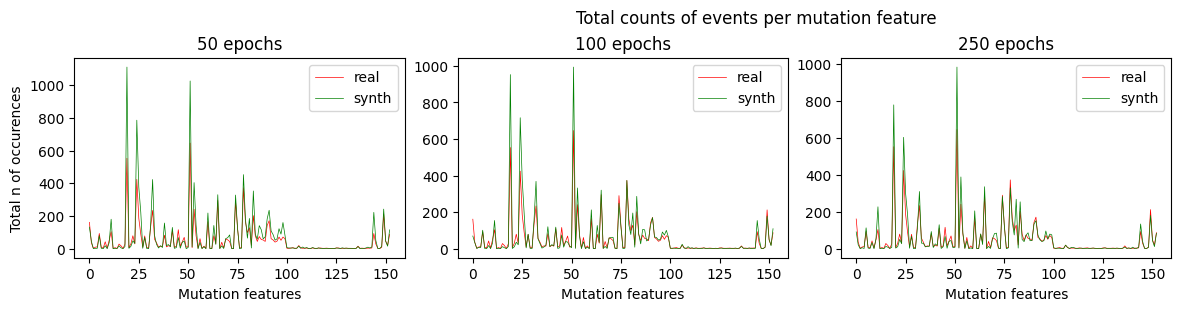

In [58]:
models_to_show = []
for model in models:
    if "no status" in short_names[model]:
        models_to_show.append(model)
        
        
multiple_plot_counts_per_feature(samples_dict, data, models_to_show, features_to_consider=mutations,
                                     title=None, figsize=(15,3), cols=4, fontsize=10, 
                                     constrained_layout=False, print_total_values=False)

# Instances of the same rows

Let's count the number of instances of each unique rows in each dataframe. This is important to correctly interpret the number of duplicates and the number of copies.
For example, let's say we have 80% duplicates. Does that mean that we have the same row duplicated 1600 times, or we have 800 rows repeated two times each? (or any in between).

### Functions dealing with instances

In [16]:
def _find_instances_of_a_row(row, df):
    '''
    checks how many instances of a row are in a df
    
    WARNING: the check on the type does not work
    
    inputs:
        row (df row as a dict [eventually a row or an index - to be implemented]): the row to search for in df
        df (pd.DataFrame): the dataframe in which the row is searched for. 
        
    output:
        instances (df): dataframe containing all the instances of that row in df
    '''
    if type(row) == "pandas.core.series.Series":
        # convert to dict
        row = {key : value for key, value in zip(list(df.columns), df.loc[0].values)}
    elif True:        
        truth_df = df==row
        instances = truth_df[truth_df.all(axis=1)]
        return instances
    else:
        print("Wrong data type for 'row'")
        return False
    
    

def plot_instances_unique_counts(df, ax=None, title=None):
    '''
    counts the number of the instances of each unique row in a dataframe df with function _find_instances_of_a_row. If ax is present, plots a 
    barplot displaying counts. 
    the "instances" of a row "x" are all the rows in the dataframe equal to "x", including itself.
    For each unique row, the number of instances is counted and stored in instances_unique_counts (dict).
    
    
    df : (pandas.DataFrame) dataframe on which the instances of the rows are counted  (for my purposes, i expect to receive df[mutations]; 
            otherwise, counting on not just the mutations works but it is not meaningful in my case
    ax : (matplotlib axis object, default=None) If present, plot a barplot of the counts
    
    output:
        instances_unique_counts (dict) : keys are the index of unique rows and values are the number of instances of that row in the dataframe (including itself, so minimum count is 1)
    '''
    
    # find instances
    instances = {}
    for row_as_dict, index in zip(df.to_dict(orient="records"), df.index):
        instances[index] = _find_instances_of_a_row(row_as_dict, df)
    # instances is a dict with keys the indices of the df and values the instances of the row corresponding to that index
    # instances[0] shows the instances of row 0

    # i drop duplicates to have only unique values
    # and for each unique value i plot the number of instances (count of instances)
    df_no_dupl = df.drop_duplicates()
    # create a subset dict of instances with just unique rows 
    instances_unique = {k: instances[k] for k in df_no_dupl.index}
    # create a dict with indices of instances unique and values the count of instances
    instances_unique_counts = {k: len(instances_unique[k]) for k in instances_unique.keys()}
    
    if ax is not None:
        ax.bar(range(len(df_no_dupl.index)), instances_unique_counts.values(), color='r', edgecolor='r')
        ax.set_ylabel("N. of instances")

        if title is not None:
            title_text = title  
        else:
            title_text = "N. of instances for each row"
        
        ax.set_title(title_text)
        
    return instances_unique_counts


def find_rows_with_many_instances(df, instances_unique_counts=None, large_count_threshold=20, display_rows=True):
    """
    finds all the unique rows that have a count of instances larger than a threshold (large_count_threshold).
    instances counts are defined and counted with function plot_instances_unique_counts.
    
    inputs:
        instances_unique_counts (dict, default=None) : dictionary of counts of instnaces of unique rows as returned by plot_instances_unique_counts.
                                                        if present, this is used to look up the counts.
                                                        
        df (pandas.DataFrame) : dataframe from where the rows are taken. if instances_unique_counts is not provided, counts of the instances are
                                evaluated directly from df. 
        
        large_count_threshold (int, default=20) : the threshold over which a row is considered with "many instances"
        
        display_rows (bool, default=True) : if True, shows the subset of df of just the unique rows with many instances
        
    outputs:
        large_count (dict) : keys are the indices of the rows with many instances, values are the respective counts.
    
    """
    if instances_unique_counts is not None:
           pass
    elif df is not None:
        instances_unique_counts = plot_instances_unique_counts(df, ax)
    else: 
        print("instances and df were both None. Please supply one or the other")
        
    large_count = {}
    large_count_threshold = 20
    for index, count in instances_unique_counts.items():
        if count > large_count_threshold:
            large_count[index] = count
    if display_rows == True:
        # show rows with large count
        print("")
        print(f"------- Rows with more than {large_count_threshold} instances ------")
        print("")
        
        for index, count in large_count.items():
            print(f"row {index}, n. of instances: {count}")
            print(f"mutations:\n{list_which_mutations_are_present(df.loc[index])}")
            print("")
    return large_count

def fit_func(x, a, beta, A, B):
        return A*np.exp(-a*(x)**beta) + B 
    
def _evaluate_stretched_exp_fit(x, y):

    from scipy.optimize import curve_fit
    from scipy.stats import chisquare

    # define a function to fit with your data with the coeffiient that curve_fit will calculate. 
    # i will use a stretched exponential


    # fit the curve
    popt, pcov = curve_fit(fit_func, x, y)
    
    return popt


def stretched_exp_fit(instances_distribution, truncate=None, ax=None):
    '''
    this function evaluates the stretched exponential fit through _evaluate_stretched_exp_fit
    
    stretched exponential function: Ae^(a(x^beta)) + B
    
    if ax is passed, plots the fitted curve
    
    returns popt, list of parameters of the fit
        popt : [a, beta, A, B]
    '''

    # data to fit
    x =  list(instances_distribution.keys())
    y =  list(instances_distribution.values())

    # brute force change type to avoid errors
    x = np.array(x, dtype=float) #transform your data in a numpy array of floats 
    y = np.array(y, dtype=float) #so the curve_fit can work

    if truncate is not None:
        # select only first truncate points
        x = x[:truncate]
        y = y[:truncate]

    popt = _evaluate_stretched_exp_fit(x, y)
    
    if ax is not None:
        x_finer = np.linspace(np.min(x), np.max(list(instances_distribution.keys())), 300)
        y_target = fit_func(x_finer, *popt)
        ax.plot(x_finer, np.log10(y_target+1), c='r', label="Fitted Curve")
        ax.legend()
    return popt


def plot_number_of_instances_distribution(instances_unique_counts, ax=None, title=None, alpha=1, color="blue", x_upper_lim=50, fit_curve=False):
    """
    finds how many row have each specific number of instances. it produces a dictionary (instances_distribution) in which 
    keys are the counts of number of indices (ranging from 1 to the max number of instances of any row) and values are the
    number of rows that have said number of indices.
    if ax is provided, plots a barplot of the logarithm of the number of indices + 1 (in order to not have log10(0)). 
    
    inputs:
        instances_unique_counts (dict, default=None) : dictionary of counts of instnaces of unique rows as returned by plot_instances_unique_counts.
        ax : (matplotlib axis object, default=None) If present, plot a barplot of the degree distribution in log scale
        
    output:
        instances_distribution (dict) : keys are the counts of number of indices (ranging from 1 to the max number of instances of any row); 
                                        values are the number of rows that have that number of indices.
                                
    """
    
    # count how many unique rows have a specific count
    instances_distribution = {}
    for count in set(instances_unique_counts.values()):
        instances_distribution[count] = sum(1 for v in instances_unique_counts.values() if v == count)    

    max_degree = max(instances_distribution.keys())
    instances_distribution_temp = {key : value for (key, value) in zip(range(1, max_degree+1), np.zeros(max_degree))}
    for degree, count in instances_distribution.items():
        instances_distribution_temp[degree] = count
    instances_distribution = instances_distribution_temp

    if ax is not None:
        ax.bar(instances_distribution.keys(), np.log10(np.array(list(instances_distribution.values()))+1), alpha=alpha, color="blue", linewidth=0)
        ax.set_xlabel("Number of instances")
        ax.set_ylabel("log10(1 + count)")
        ax.set_xlim([0,x_upper_lim])
    
    if title is not None:
        title_text = title
    else:
        title_text = "N. of instances distribution"    
    ax.set_title(title_text)        

    if fit_curve:
        try:
            # fit the stretch exp and plot the fitted curve
            popt = stretched_exp_fit(instances_distribution, truncate=15, ax=ax)
        except RuntimeError as re:
            print(re)
        return instances_distribution, popt
    
    return instances_distribution
 


def plot_number_of_instances_distribution_condensed(instances_unique_counts, ax=None, title=None, alpha=1, color="blue", x_upper_lim=50, ylabel=False):
    """
    this is basically the same of plot_number_of_instances_distribution, but produces a smaller and tighter plot with less information.
                                
    """
    
    # count how many unique rows have a specific count
    instances_distribution = {}
    for count in set(instances_unique_counts.values()):
        instances_distribution[count] = sum(1 for v in instances_unique_counts.values() if v == count)    

    max_degree = max(instances_distribution.keys())
    instances_distribution_temp = {key : value for (key, value) in zip(range(1, max_degree+1), np.zeros(max_degree))}
    for degree, count in instances_distribution.items():
        instances_distribution_temp[degree] = count
    instances_distribution = instances_distribution_temp

    if ax is not None:
        ax.bar(instances_distribution.keys(), np.log10(np.array(list(instances_distribution.values()))+1), alpha=alpha, color="blue", linewidth=0, width=1.5)
        ax.set_xlabel("N. of instances", fontsize=6)
        if ylabel == True:
            ax.set_ylabel("log10(1 + count)", fontsize=6)
        ax.set_xlim([0,x_upper_lim])
        ax.set_title(title, fontsize=6)
    
    return instances_distribution


def get_instances_info(df, ax_instances=None, ax_instances_distr=None, 
                       title=None, 
                       display_rows_with_many_instances=False,
                       plot_text_box=True,
                       alpha=1, color="blue", x_upper_lim=50, fontsize=8):
    '''
    simple all-in-one function regarding instances. it does:
        - counting the number of instances with instances_unique_counts
        - finding rows with many instances with find_rows_with_many_instances
        - plotting the instances distributions with plot_number_of_instances_distribution
        
    inputs:
    
    df (pandas.DataFrame) : df on which the instances are searched
    ax_instances (matplotlib axes, default=None) : if present, plots the n. of instances per row (see plot_instances_unique_counts for info)
    ax_instances:distr (matplotlib axes, default=None) : if present, plots the distribution of n. of instances per row (see plot_number_of_instances_distribution for info)
    title (str, default=None) : name of the plot to be attached in the title. it is passed to both plot_instances_unique_counts and plot_number_of_instances_distribution
    display_rows_with_many_instances (bool, default=False): if true, displays the mutations of the rows with many indices, passing display_rows=True to plot_instances_unique_counts
    plot_text_box (bool, default=False): if true, plots a text box in the instances distr plot with info

    outputs:
    
    instances_unique_counts : see plot_instances_unique_counts for info
    large_count : see find_rows_with_many_instances for info
    instances_distribution : see plot_number_of_instances_distribution for info

    '''
    
    instances_unique_counts = plot_instances_unique_counts(df, ax_instances, title)
    large_count = find_rows_with_many_instances(df, instances_unique_counts, display_rows=display_rows_with_many_instances)
    instances_distribution, popt = plot_number_of_instances_distribution(instances_unique_counts, ax_instances_distr, title, alpha, color="blue", x_upper_lim=50)    
    if (ax_instances_distr is not None) and (plot_text_box == True):    
        t_many_inst = f"Number or rows with many instances: {str(len(large_count))}" 
        t_max_count = f"Maximum count: {str(max(large_count.values()))}"
        t_one_inst = f"N of rows with 1 instance: {str(instances_distribution[1])}"
        if popt is not None:
            t_exp = f"Fitted curve: Ae^(a(x)^beta) + B:\n"
            t_exp = t_exp + f"a = {popt[0]:.4f}\nbeta = {popt[1]:.4f}\n"
        for index, count in large_count.items():
            t_comm_rows = "Rows with many instances:\n"
            mutations = list_which_mutations_are_present(df.loc[index])
            t_comm_rows = t_comm_rows + f"mutations: {mutations} ; count = {count}\n"
        text = t_many_inst+"\n"+t_max_count+"\n"+t_one_inst+"\n"+t_comm_rows
        text_x, text_y = (20, 1.5)
        ax_instances_distr.text(text_x, text_y, text, fontsize=fontsize, ha='left', wrap=True, bbox=dict(boxstyle="square",
                        ec=(.5, 0.5, 0.5),
                        fc=(.95, 0.95, 0.95),))
    return instances_unique_counts, large_count, instances_distribution



def get_instances_info_condensed(df, ax_instances=None, ax_instances_distr=None, 
                       title=None, 
                       alpha=1, color="blue", x_upper_lim=50, fontsize=8, ylabel=False):
    '''
    This is equivalent to get_instances_info, but produces smaller plots with less information on it
    '''
    
    instances_unique_counts = plot_instances_unique_counts(df, ax_instances, title)
    large_count = find_rows_with_many_instances(df, instances_unique_counts)
    instances_distribution = plot_number_of_instances_distribution_condensed(instances_unique_counts, ax_instances_distr, title, alpha, color="blue", x_upper_lim=50, ylabel=ylabel)    
    t_many_inst = f"Number or rows with many instances: {str(len(large_count))}" 
    t_max_count = f"Maximum count: {str(max(large_count.values()))}"
    t_one_inst = f"N of rows with 1 instance: {str(instances_distribution[1])}"
    for index, count in large_count.items():
        t_comm_rows = "Rows with many instances:\n"
        mutations = list_which_mutations_are_present(df.loc[index])
        t_comm_rows = t_comm_rows + f"mutations: {mutations} ; count = {count}\n"
    text = t_many_inst+"\n"+t_max_count+"\n"+t_one_inst+"\n"+t_comm_rows
    text_x, text_y = (20, 1.5)
    ax_instances_distr.text(text_x, text_y, text, fontsize=7, ha='left', wrap=True, bbox=dict(boxstyle="square",
                    ec=(.5, 0.5, 0.5),
                    fc=(.95, 0.95, 0.95),))
    return instances_unique_counts, large_count, instances_distribution

### Instances distributions plots


------- Rows with more than 20 instances ------

row 64, n. of instances: 50
mutations:
[]

row 66, n. of instances: 39
mutations:
['DNMT3A', 'ITD', 'NPM1']


------- Rows with more than 20 instances ------

row 11, n. of instances: 40
mutations:
['DNMT3A', 'ITD', 'IDH2_p.R140', 'NPM1']

row 39, n. of instances: 34
mutations:
['DNMT3A', 'ITD', 'NPM1']

row 61, n. of instances: 29
mutations:
['DNMT3A', 'ITD', 'NPM1', 'TET2']


------- Rows with more than 20 instances ------

row 8, n. of instances: 31
mutations:
['DNMT3A', 'ITD', 'IDH2_p.R140', 'NPM1']

row 15, n. of instances: 39
mutations:
['DNMT3A', 'ITD', 'NPM1']

row 24, n. of instances: 36
mutations:
['DNMT3A', 'ITD', 'NPM1', 'TET2']


------- Rows with more than 20 instances ------

row 18, n. of instances: 22
mutations:
['DNMT3A', 'IDH2_p.R140', 'NPM1']

row 91, n. of instances: 40
mutations:
['DNMT3A', 'ITD', 'NPM1']



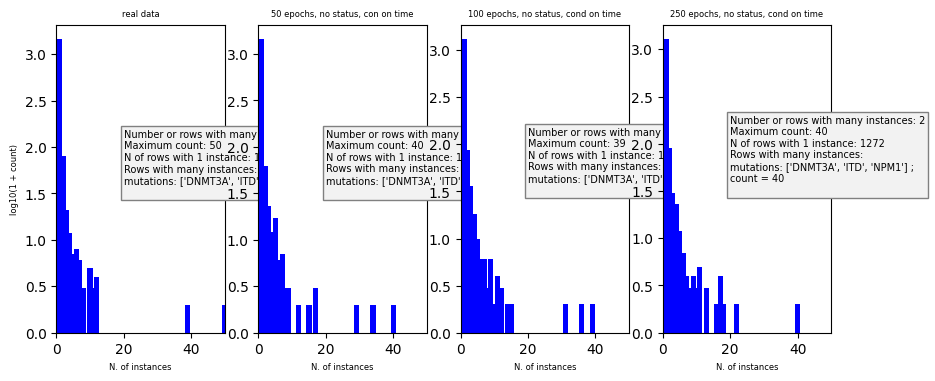

In [17]:
models_to_show = []
for model in models:
    if "no status" in short_names[model]:
        models_to_show.append(model)
    
ncols = 4
nrows = ( len(models_to_show) + 1 ) // ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,4))


axs = trim_axs(axs, (len(models_to_show)+1))

# plot real data in first graph
instances_unique_counts, large_count, instances_distribution = get_instances_info_condensed(data[mutations], 
                                                                                      ax_instances_distr=axs[0], 
                                                                                      title="real data", 
                                                                                      fontsize=4, ylabel=True)

for model, ax in zip(models_to_show, axs[1:]):
    instances_unique_counts, large_count, instances_distribution = get_instances_info_condensed(samples_dict[model][mutations], 
                                                                                      ax_instances_distr=ax, 
                                                                                      title=short_names[model], 
                                                                                      fontsize=4)

# Distribution of number of mutations per row

In [53]:
# count number of mutations per row

n_mutations = {"real_data" : []}

for model in models_to_show:
    n_mutations[model] = []
for n_of_mutations in list(range(0, 50)):
    mutation_count = sum((data[mutations] != 0).sum(axis=1) == n_of_mutations)
    n_mutations["real_data"].append(mutation_count)
    for model in models_to_show:
        mutation_count = sum((samples_dict[model][mutations] != 0).sum(axis=1) == n_of_mutations)
        n_mutations[model].append(mutation_count)

# plot
fig, ax = plt.subplots()

ax.plot(list(range(0, 50)), n_mutations["real_data"], label='real data')

for model in models_to_show:
    ax.plot(list(range(0, 50)), n_mutations[model], label=short_names[model])
    
ax.legend(loc='upper right')
ax.set_xlim([0, 12])
ax.set_title("distribution of n of mutations per row")
ax.set_ylabel("row count")
ax.set_xlabel("n of mutations")

# Time distribution

### Functions 

In [155]:
def info_about_time(df):
    """ function to get various simple statistics about "status" and "time" features of df"""
    print("Statistics of time:")
    print(df.time.describe())
    print("")
    print(f"Number of unique values for time: {len(df.time.unique())}")
    n_alive = sum(df[df.time == df.time.max()].status == 0)
    print(f'Number of people with the maximum value {df.time.max()} for time: {len(df.time[df.time == df.time.max()])}, {n_alive} alive')

    fig, axs = plt.subplots(nrows=2, layout="constrained")

    # sns.displot(df, x="time", title=short_names[name])
    axs[0].hist(df["time"])
    axs[0].set_xlabel("time")
    axs[0].set_ylabel("count")
    axs[1].hist(df["status"])
    axs[1].set_xlabel("status")
    axs[1].set_ylabel("count")
    
def compare_infos_about_time(df_list, names=None):
    """ function to get various simple statistics about "status" and "time" features of dfs in df_list 
    and plot them side by side
    
    """
    
    for df, name in zip(df_list, names):
        if name is not None:
            print(name)
        print("Statistics of time:")
        print(df.time.describe())
        print("")
        print(f"Number of unique values for time: {len(df.time.unique())}")
        n_alive = sum(df[df.time == df.time.max()].status == 0)
        print(f'Number of people with the maximum value {df.time.max()} for time: {len(df.time[df.time == df.time.max()])}, {n_alive} alive')
    
    ncols=len(df_list)
    fig, axs = plt.subplots(nrows=3, ncols=ncols, sharey=False, constrained_layout=True, 
                            gridspec_kw={'hspace': 0.1, 'wspace': 0.01, 'width_ratios': [0.5]*ncols})
    labelpad_x = 0
    # Create common y-axis label for the entire row
    axs[0, 0].set_ylabel("log(count)")
    axs[1, 0].set_ylabel("log(count)")
    axs[2, 0].set_ylabel("status")
    for df_index in range(ncols):
        # sns.displot(df, x="time", title=short_names[name])
        axs[0, df_index].hist(df["time"], log=True)
        axs[0, df_index].set_xlabel("time", labelpad=labelpad_x)

        axs[1, df_index].hist(df["status"], log=True)
        axs[1, df_index].set_xlabel("status", labelpad=labelpad_x) 
        axs[1, df_index].set_xticks([0,1])
        
        axs[2, df_index].scatter(df["time"], df["status"], s=0.5, alpha=0.8)
        axs[2, df_index].set_xlabel("time", labelpad=labelpad_x)   


### Plots

real data
Statistics of time:
count    2017.000000
mean        4.515715
std         4.838551
min         0.002738
25%         0.511978
50%         1.596167
75%        11.208761
max        11.208761
Name: time, dtype: float64

Number of unique values for time: 738
Number of people with the maximum value 11.2087611225188 for time: 668, 668 alive
500 epochs, no clust, w/status&time
Statistics of time:
count    2017.000000
mean        1.015837
std         1.164666
min         0.002738
25%         0.194387
50%         0.725530
75%         1.295003
max        11.208761
Name: time, dtype: float64

Number of unique values for time: 552
Number of people with the maximum value 11.2087611225188 for time: 1, 1 alive
100 epochs, no clust, no dupl, w/status&time
Statistics of time:
count    2017.000000
mean        1.161537
std         1.382314
min         0.000000
25%         0.260096
50%         0.788501
75%         1.535934
max        11.208761
Name: time, dtype: float64

Number of unique values f

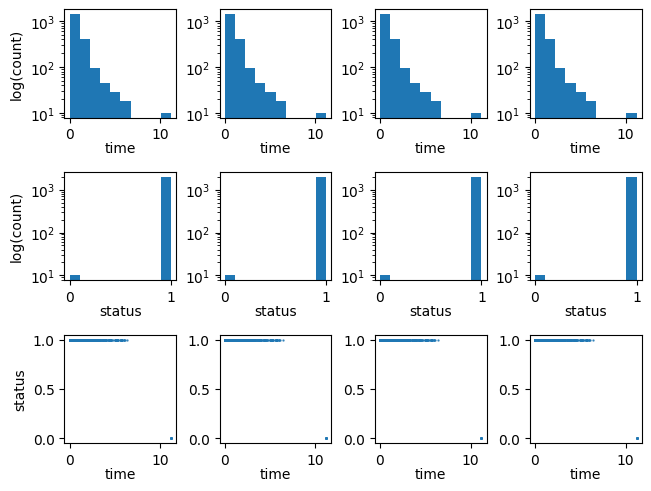

In [156]:
df_list_to_show = [data]
names_to_show = ["real data"]
names_to_show = names_to_show + list(short_names.values())[3:6]

for model in models[3:6]:
        df_list_to_show.append(samples_dict[model])
        
compare_infos_about_time(df_list_to_show, names_to_show)

# UMAP dimensionality reduction

## UMAP plot of real data with color meaning time

In [71]:
def umap_plot(df, n_neigbours, title):

    import umap

    train_data = select_only_mutation_features(df)
    trans = umap.UMAP(n_neighbors=n_neigbours, random_state=42).fit(train_data)
    
    fig, ax = plt.subplots()
    cs = ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=df["time"], cmap='Spectral')
    cbar = fig.colorbar(cs, label="time")
    fig.suptitle(f'UMAP Embedding learned on real data\nReal (red) and Synth (blue) data represented in this embedding\n{title}', fontsize=10);

D:\Users\aless\Desktop\Universita\castellani\syntheticdatageneration\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


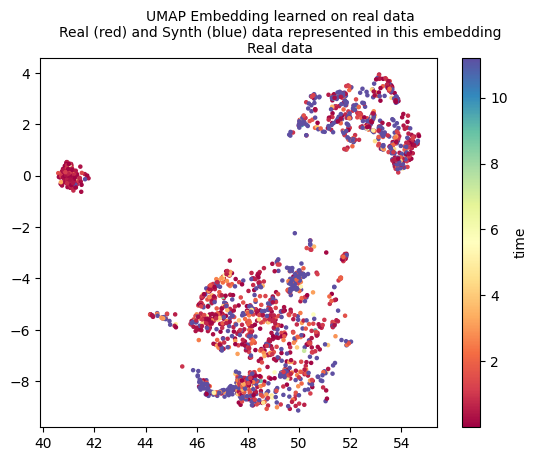

In [42]:
umap_plot(data, "Real data")

## Synth vs Real in UMAP space

We will train UMAP on real data, and then plot both real data and synth data in the UMAP space learned on real data

From the [UMAP tutorials](https://umap-learn.readthedocs.io/en/latest/exploratory_analysis.html)

In [48]:
def umap_plots(data, samples_dict, models, short_names, n_neighbours, figsize=(10,8), cols=3):

    import umap

    figsize = (10,8)
    cols = 3
    rows = len(models) // cols + 1

    fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axs = trim_axs(axs, len(models))
    
    features_to_drop = ["status", "time"]
    train_data = data.drop(features_to_drop, axis=1)
    train_data = train_data.drop("my_kmeans", axis=1)
    trans = umap.UMAP(n_neighbors=n_neighbours, random_state=42).fit(train_data)

    for model, ax in zip(models, axs):
        # transform synth data in the umap embedding learned on real data       
        if "my_kmeans" in samples_dict[model].columns:
            features_to_drop.append("my_kmeans")
            
        synth_data = samples_dict[model].drop(features_to_drop, axis=1)
        
        # plot real data with umap embedding
        ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c='r')
        
        # transform synth data in the umap embedding learned on real data    

        synth_embedding = trans.transform(synth_data)
        ax.scatter(synth_embedding[:, 0], synth_embedding[:, 1], s= 5, c='b')

        ax.set_title(short_names[model], fontsize=6)
        
    fig1.suptitle(f'UMAP Embedding learned on real data\nReal (red) and Synth (blue) data represented in this embedding', fontsize=10);

D:\Users\aless\Desktop\Universita\castellani\syntheticdatageneration\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


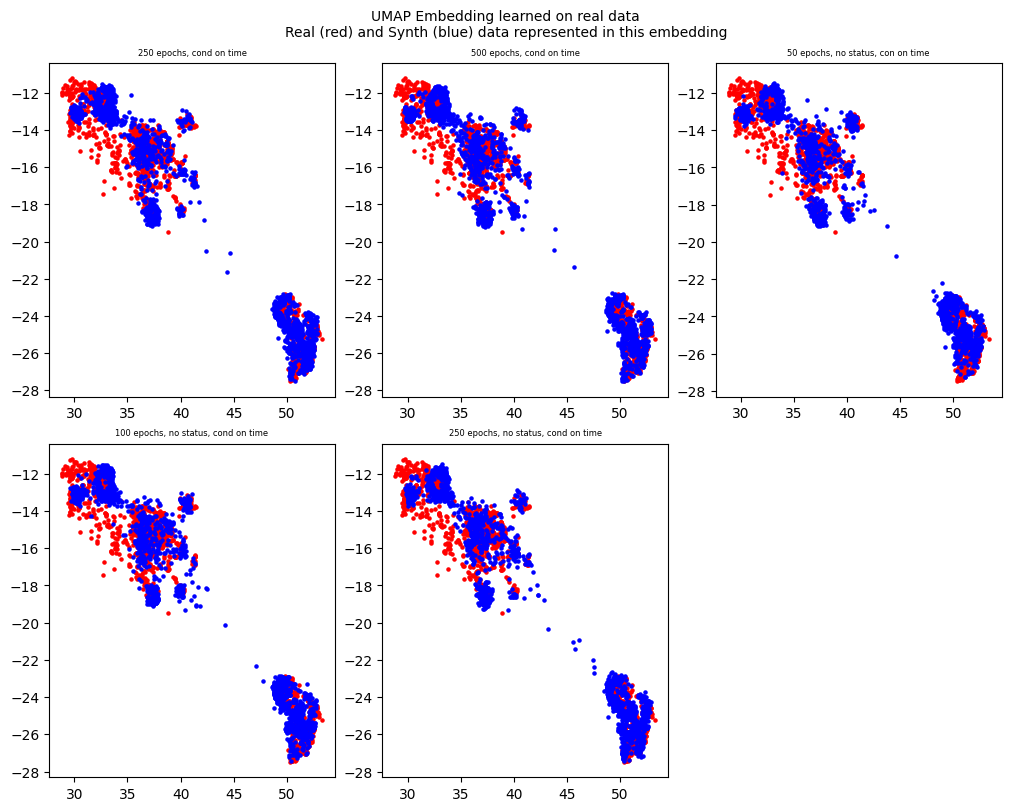

In [49]:
umap_plots(data, samples_dict, models_to_show, short_names, n_neighbours=80, figsize=(10,8), cols=3)

# Correlations

i'll use PHI, the matthews correlation coefficient, that is a measure of associativity between dicothomous data.

Text(0.5, 1.0, 'Correlation Matrix, Real Data (only mutations)')

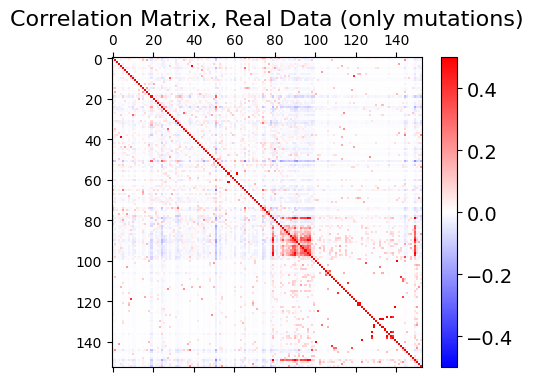

In [50]:
f = plt.figure(figsize=(5, 4))
plt.matshow(data[mutations].corr(), fignum=f.number, vmin=-.5, vmax=.5, cmap='bwr')
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=4, rotation=45)
# plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=4)
cb = plt.colorbar()

cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix, Real Data (only mutations)', fontsize=16)
# plt.savefig(f'corr_real.png')

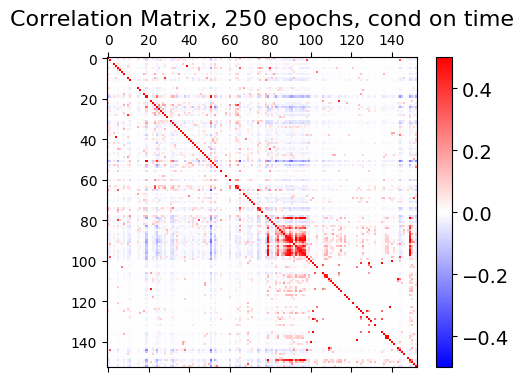

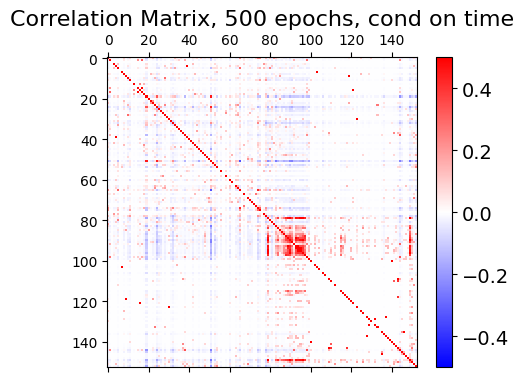

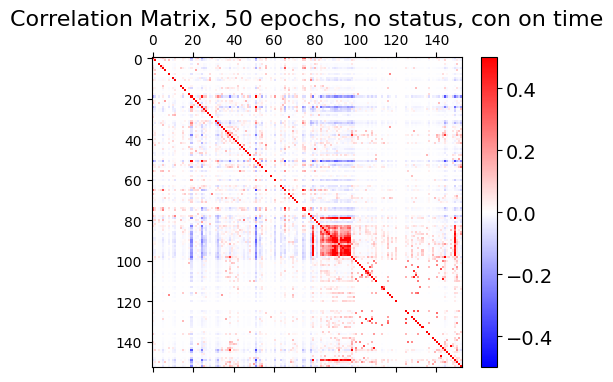

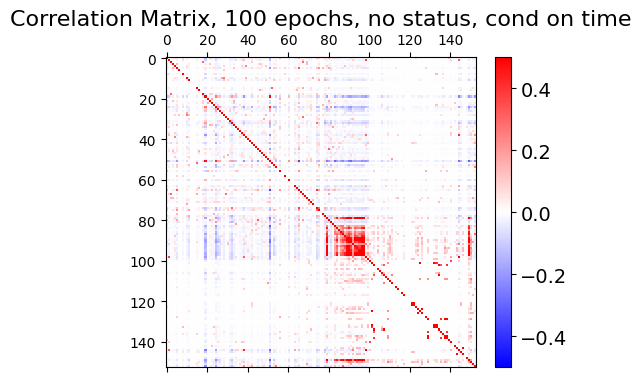

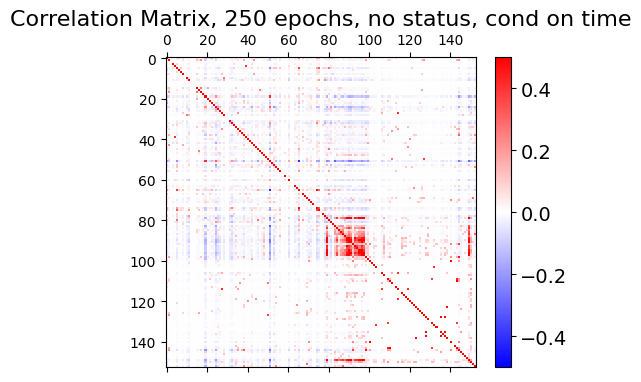

In [18]:
for name in models_to_show:
    df = samples_dict[name][mutations]
    f = plt.figure(figsize=(5, 4))
    corr_matrix = df.corr().fillna(0)
    plt.matshow(df.corr().fillna(0), fignum=f.number, vmin=-.5, vmax=.5, cmap='bwr')
    # plt.xticks(range(df.select_dtypes(['number']).shape[1])[::10], df.select_dtypes(['number']).columns[::10], fontsize=14, rotation=45)
    # plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=4)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'Correlation Matrix, {short_names[name]}', fontsize=16)
    # plt.savefig(f'plots and images/aml/correlations/corr_{name}.png')

# K-Means clustering

### Building a clustering pipeline with sklearn.pipeline

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score

random_state=338
n_clusters=16
n_init=500   # n of centroid initializations.
max_iter=5000   # max n of iter per centroid initialization

#define a preprocessor
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        #("pca", PCA(n_components=2, random_state=random_state))
    ]
)

# define a clusterer
clusterer = Pipeline(
    [
        ("kmeans", KMeans(n_clusters=n_clusters,
                          init="k-means++",
                          n_init=n_init,             
                          max_iter=max_iter,          
                          random_state=random_state,
                         ),
        ),
    ]
)

### Find the clusters 

In [63]:
# do the clusterings

group_names_clustering = models
for name in group_names_clustering:
    for name in models:
        samples = samples_dict[name]
        # chain together the preprocessor and the clusterer to form a pipe
        pipe = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("clusterer", clusterer)
            ]
        )

        
        # perform the pipeline (preprocessor + clusterer
        pipe.fit(samples[mutations])

        predicted_labels = pipe["clusterer"]["kmeans"].labels_ # these are the predicted label for the clustering
        samples["new_kmeans"] = predicted_labels
        
        # save in a new file (because the clustering takes a lot of time)
        filename = filepath+"with_new_kmeans/"+name+"_run{run}.csv"
        samples.to_csv(filename)


### Load previously found clusters

In [ ]:
group_names_clustering = models
for name in group_names_clustering:
    for run in range(10):
        filename = filepath+"with_new_kmeans/"+name+"_run{run}.csv"
        samples_dict[name][run] = pd.read_csv(filename) 
        # drop unnamed column (that is generated when reading)
        samples = samples.drop(samples.columns[samples.columns.str.contains('unnamed', case=False)], axis=1)

# Survival Analysis

In [ ]:
def survival_function(df, ax=None, title=None):
    
    '''
    evaluates survival functions with a kaplan meier fitter.
    
    inputs:
    
        df (dataframe): dataframe on which evaluate the survival analysis. 
                        It should contain a "time" and "status" feature.
        ax (matplotlib ax): if not None, it plots the survival curve
        title (string): title to show on the plot
    
    outputs: 

        survival function (KaplanMeierFitter object) and relative confidence interval  
    '''
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()

    time = df['time']
    event = df['status']
    kmf.fit(time, event)
    confidence_interval = kmf.confidence_interval_survival_function_
    
    if ax is not None:
        ts = confidence_interval.index
        low, high = np.transpose(confidence_interval.values)

        kmf.survival_function_.plot(ax=ax, legend=False, xlabel="", ylabel="")
        ax.fill_between(ts, low, high, alpha=0.3)

        if title is not None:
            ax.set_title(title)
            
    return kmf.survival_function_, kmf.confidence_interval_survival_function_


### Survival analysis (all data)

Text(0.5, 0.98, 'Survival Analysis\nReal (red), synth (blue)')

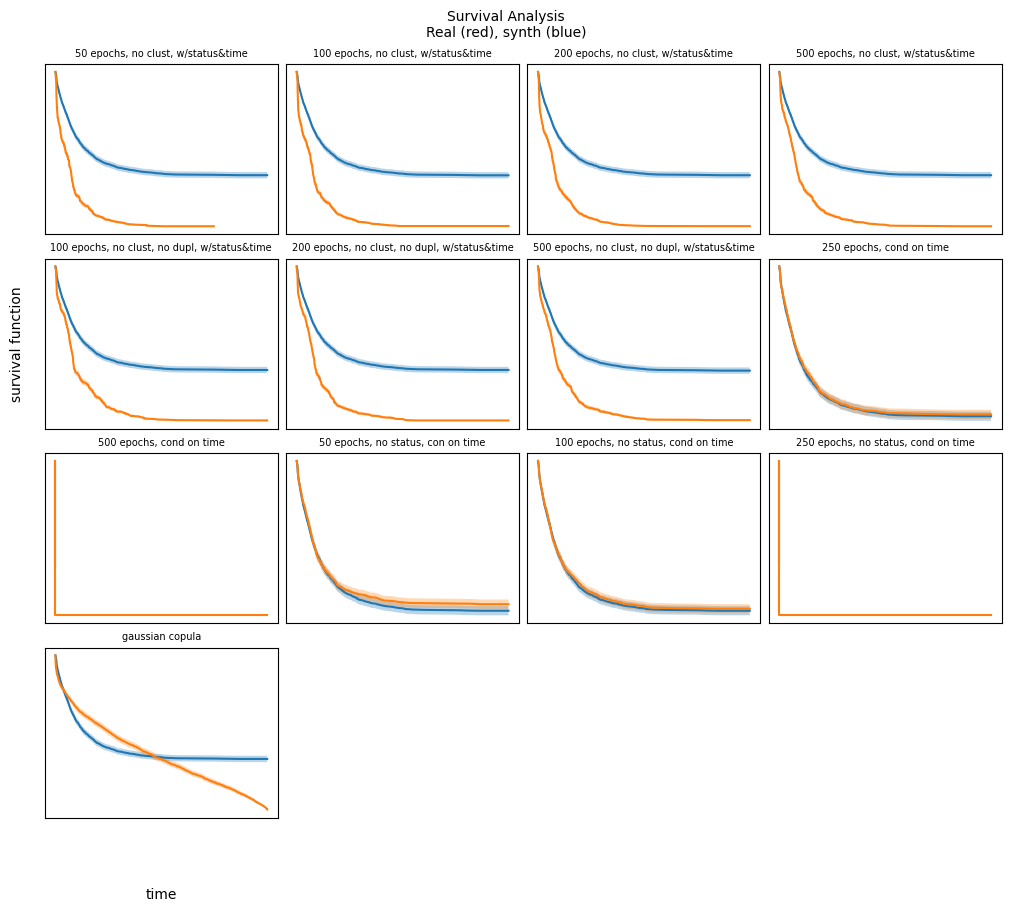

In [159]:
nrows = 4
ncols = len(models) // nrows + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,9), layout="constrained")
axs = trim_axs(axs, len(models))
for model, ax in zip(models, axs):
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    survival_function(data, ax)
    survival_function(samples_dict[model], ax)
    ax.set_title(short_names[model], fontsize=7)
axs[4].set_ylabel("survival function", labelpad=15)
axs[-1].set_xlabel("time", labelpad=50)
fig.suptitle(f"Survival Analysis\nReal (red), synth (blue)", fontsize=10)

## Survival analysis, first 4 clusters

In [190]:
def plot_survival_first_n_clusters(models, n_clusters_to_show=4, 
                                   samples_dict=samples_dict, short_names=short_names, 
                                   ax_title_fontsize=7, ncols=4,figsize=(10,9)):
    
    '''
    this uses survival_function to plot the survival curves for the first n_clusters_to_show clusters
    '''
    
    nrows = (len(models) + 1) // ncols + 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout="constrained")
    axs = trim_axs(axs, len(models)+1)

    axs[0].set_title("real data", fontsize=ax_title_fontsize)
    for cluster in range(n_clusters_to_show):
        survival_function(data[data["my_kmeans"]==cluster], axs[0])

    i = 1
    for model, ax in zip(models, axs[1:]):
        ax.set_title(short_names[model], fontsize=ax_title_fontsize)
        if (i // ncols) != (i / ncols): 
            ax.set_yticks([])
            ax.set_yticks([], minor=True)
            ax.set_ylabel("survival function")

        for cluster in range(n_clusters_to_show):
            survival_function(samples_dict[model][samples_dict[model]["new_kmeans"]==cluster], ax)
        i = i+1
    axs[-1].set_xlabel("time", labelpad=50)
    fig.suptitle(f"Survival Analysis\nLargest 4 clusters", fontsize=10)
    
    

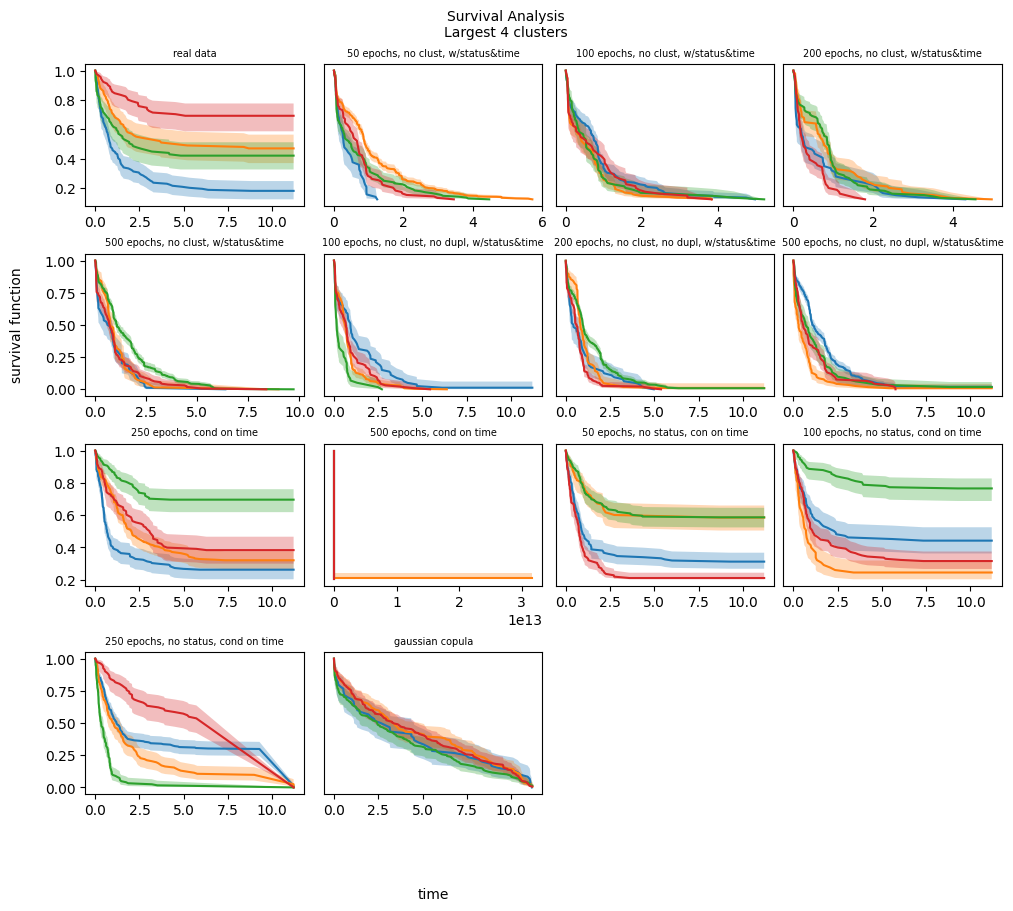

In [179]:
plot_survival_first_n_clusters(models, n_clusters_to_show=4, 
                                   ax_title_fontsize=7, nrows=4,figsize=(10,9))

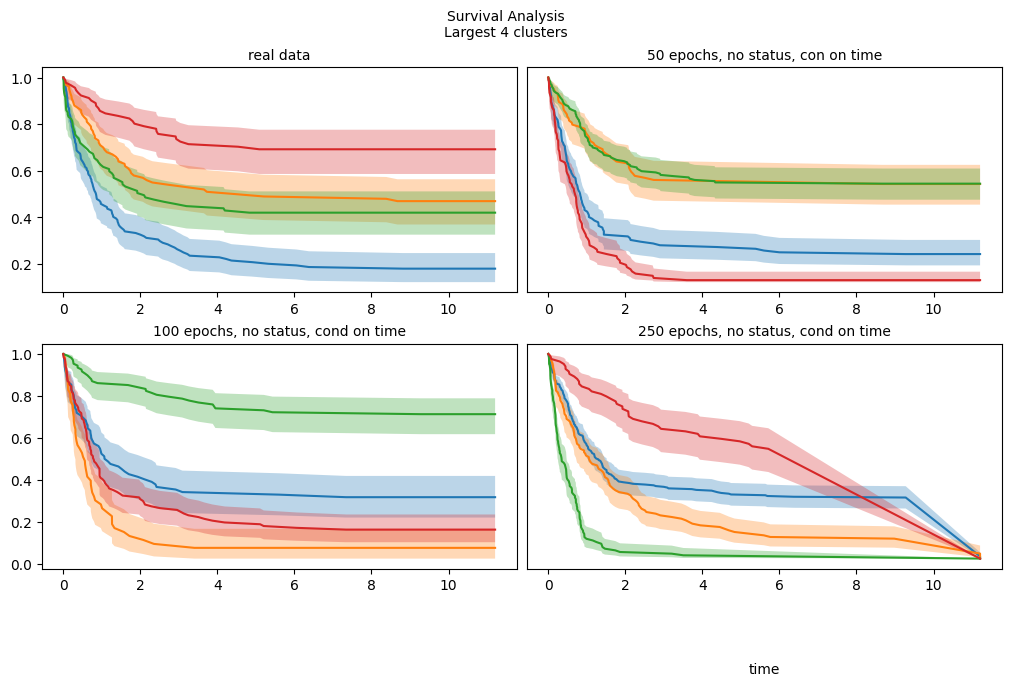

In [192]:
models_to_show = [model for model in models if "status" not in model]
models_to_show = models_to_show[:-1]
plot_survival_first_n_clusters(models_to_show, n_clusters_to_show=4, 
                                   ax_title_fontsize=10, ncols=2,figsize=(10,9))

# Classification (target: status)

### Functions for classification

In [17]:
# --- IMPORTS AND DEFINING OF FUNCTIONS FOR CLASSIFICATION ---
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score


def model_with_loo_cross_validation(X, y, model):
    '''
    function to train and test the model with leave-one-out cross validation
    INPUTS:
        X : features
        y : target 
        model : the sklearn model to use as a classifier 
    OUTPUT: 
        accuracy score
    '''
    # Instantiating the K-Fold cross validation object with 5 folds
    loo = LeaveOneOut()
    # make prediction
    y_predicted = cross_val_predict(model, X, y, cv=loo, n_jobs=-1, method='predict')
    # evaluate scores from the prediction
    score = accuracy_score(y, y_predicted, normalize=True)
    
    return score

    
def loo_cross_validation_scores(data, target_col, cols_for_training):
    ''' Evaluate scores of leave-one-out cross validation on data
    INPUTS:
        data (pd.df) : dataframe on which to evaluate the cross_val
        target_col (str) : target feature of data
    OUTPUTS: 
        cross_val_score : dict of the score of the 4 classifiers: cross_val_score = {"Logistic Regression": cross_val_score of log reg, "SVM": cross_val_score of SVM,..}
    '''
    # Preparing the data to do the training with cross-validation on just the real dataset
    # DEFINE THE VARIABLES
    # Define the X (known data) and y (value to predict) of real data. (i will train and test on this with cross validation).
    X_real = data[cols_for_training].copy()
    y_real = data[target_col].copy()
    # NORMALIZATION
    # rescaling and normalizing data before the training
    sc = StandardScaler()
    sc.fit(X_real)
    X_real_std = sc.transform(X_real)
    # initialize cross_validation score
    cross_val_score = {}
    # logistic regression (cross-validation)
    cross_val_score["Logistic Regression"] = model_with_loo_cross_validation(X_real_std, y_real, model=LogisticRegression(random_state=0, solver="sag"))
    # SVM  (cross-validation)
    cross_val_score["SVM"] = model_with_loo_cross_validation(X_real_std, y_real, model=SVC())
    # KNN (cross-validation)
    cross_val_score["KNN"] = model_with_loo_cross_validation(X_real_std, y_real, model=KNeighborsClassifier())
    # Random Forest (cross-validation)
    cross_val_score["Random Forest"] = model_with_loo_cross_validation(X_real_std, y_real, model=RandomForestClassifier())
    
    return cross_val_score


def classification_scores(samples, data, classifier_names, target_col, cols_for_training):
    '''
    evaluate the train and test scores for 4 classifiers by evaluating them on several runs of the same model and averaging
    training on synth dataset (from samples_list) testing on real data (data)
    the 4 classifiers are, in order: logistic regression, svm, knn, randomforest (from sklearn)
    
    INPUTS:
        - samples : synthetic dataframe
        - data : real data 
        - cols for training
        
    OUTPUTS:
        - scores : dict of the scores where the keys are the classifiers
        - table_data : list of strings; same infos of scores but formatted in a table
    '''    
    

    # --- TRAINING AND TESTING ---
    # initialize empty lists in which i will put the train_scores dict and test_scores dict for all datasets of the group (all runs)
    train_scores = dict.fromkeys(classifier_names)
    test_scores = dict.fromkeys(classifier_names)
    


    # Preparing the data to do the training on the synth. data and the testing on the real data
    # --- DEFINE THE VARIABLES ---
    if cols_for_training is None:
        cols_for_training = samples.drop(target_col, axis=1).columns
        # define the X (known data) and y (value to predict) that I will use for the training. I will train on the samples.
    X_train = samples[cols_for_training].copy()  # use only "cols_for_training"
    y_train = samples[target_col].copy()
    # define the X (known data) and y (value to predict) that I will use for the testing. I will test on the samples + new_kmeans
    X_test = data[cols_for_training]
    y_test = data[target_col]
    # --- NORMALIZATION ---
    # RESCALING AND NORMALIZING data before the training
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    # X_train_std and X_test_std are the scaled datasets to be used
    # --- FITTING OF THE CLASSIFIERS ---
    # logistic regression
    log_reg = LogisticRegression(random_state=0, solver="sag").fit(X_train_std, y_train)
    # SVM
    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 7, p = 2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    # Random Forest
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train_std, y_train)
    # --- ACCURACY SCORES ---
    # save the accuracy scores for this dataset
    train_scores["Logistic Regression"] = log_reg.score(X_train_std, y_train)
    test_scores["Logistic Regression"] =  log_reg.score(X_test_std, y_test)
    train_scores["SVM"] = svm.score(X_train_std, y_train)
    test_scores["SVM"] =  svm.score(X_test_std, y_test)
    train_scores["KNN"] = knn.score(X_train_std, y_train)
    test_scores["KNN"] =  knn.score(X_test_std, y_test)
    train_scores["Random Forest"] = random_forest.score(X_train_std, y_train)
    test_scores["Random Forest"] =  random_forest.score(X_test_std, y_test)
    # END ON TRAINING ON SYNTH
        
    return train_scores, test_scores 


                                                     
# --- PRINT TABLE ---
# FUNCTION TO FORMAT DATA FOR A TABLE
def format_table(train_score_avg, train_score_std, test_score_avg, test_score_std, cross_val_score, classifier_names):    
    """# --- FORMAT TABLE --- 
    """
    # initialize table data with the first column
    table_data =  [
                ['Logistic Regression'],
                ['SVM'],
                ['KNN'],
                ['Random Forest']
                ]
    # append the scores to each row
    for i in range(len(table_data)): 
        table_data[i].append(f"{train_score_avg[classifier_names[i]]:.3f} \u00B1 {train_score_std[classifier_names[i]]:.3f}")
        table_data[i].append(f"{test_score_avg[classifier_names[i]]:.3f} \u00B1 {test_score_std[classifier_names[i]]:.3f}")
        table_data[i].append(f"{cross_val_score[classifier_names[i]]:.3f}")

    return table_data
    

In [52]:
# This cell contains functions of higher order wrt the previous cell
# these functions use function of previous cell to evaluate and visualize classifications on multiple samples dfs

def evaluate_classification_on_multiple_models(samples_dict, data, group_names_classification, target_col, cols_for_training):
    
    ''' 
    group_names_classification are the keys to use for selecting samples in samples_dict
    i assume that the classifiers are trained on the same featuers, defined in "cols_for_training" and on the same target, defined in "target_col"
    '''
    # save classifier names in a list for using them as keys of the dicts I will create and also for plotting 
    classifier_names = ["Logistic Regression", "SVM", "KNN", "Random Forest"]
    # initialize dictionary of train_scores_dict and test_scores_dict. 
    #These are structured as follows: train_scores_dict[group_name] -> train_scores_dict[group_name][classifier] = train score for classifier for group name
    train_scores_dict = {}
    test_scores_dict = {}

    for name in group_names_classification:
        # the dictionaries with dictionaries, with keys corresponding to group names
        train_scores_dict[name] = {}
        test_scores_dict[name] = {}

    # --- FIND TRAIN AND TEST ACCURACIES ---
    for name in group_names_classification:
        # do the classifications on 10 synth datasets generated froma a model trained for 100 epochs
        train_scores, test_scores = classification_scores(samples_dict[name],            
                                                          data=data,
                                                          classifier_names=classifier_names,
                                                          target_col=target_col,
                                                          cols_for_training=cols_for_training)
        # save the dict of scores for the model
        train_scores_dict[name] = train_scores
        test_scores_dict[name] = test_scores
            
        # --- FIND CROSS-VALDITATION ACCURACY ---

    cross_val_score = loo_cross_validation_scores(data.copy(), target_col, cols_for_training)
        
    return train_scores_dict, test_scores_dict, cross_val_score 
    
#______________________________________________________________________________________________________________________________________


def barplot_classification_scores(classification_accuracy_scores, group_names_classification, text_coord, samples_metadata):
    '''
    # --- --- BARPLOTS FOR THE ACCURACY (one bar plot for classifier, one bar for model) --- 
        
    '''
    
    # unpack the scores
    (train_scores_dict, test_scores_dict, cross_val_score) = classification_accuracy_scores
    
    # PARAMETERS FOR THE PLOT
    width = 0.5
    separator = 1
    alpha = 0.5
    capsize = 0
    classifier_names = ['Logistic Regression', 'SVM' , 'KNN', 'Random Forest']

    # intiialize bars
    bars_train = {}
    bars_test = {}
    bars_cross_val = {}
    for classifier in classifier_names:
        bars_train[classifier] = {}
        bars_test[classifier] = {}
        bars_cross_val[classifier] = {} 
        
    # plot a different plot for each classifier 
    for classifier in classifier_names:
        # define bars
        for (name, x_pos) in zip(group_names_classification, range(len(group_names_classification))):
            # set values to bars
            bars_train[classifier][name] = plt.bar(x_pos, train_scores_dict[name][classifier],
                                                   width, color = 'r', alpha=alpha, capsize=capsize)  # training acc
            bars_test[classifier][name] = plt.bar(x_pos+width, test_scores_dict[name][classifier],
                                                  width, color='g', alpha=alpha, capsize=capsize)  ## test acc
            
        bars_cross_val[classifier][name] = plt.bar(x_pos+width*2, cross_val_score[classifier], width, color = 'b', alpha=alpha, capsize=capsize)

        plt.ylim([.5, 1])
        #plt.ylabel('Number of unique values')

        title = f"Classification accuracies - {classifier}"
        plt.title(title)

        # duplicates_avg[group_names[i]]
        text = "From left to right: \n"
        for name in group_names_classification:
            text = text + f"\n  - {short_names[name]} (copies = {samples_metadata.loc[name,'copies_perc']:.0f}%)"
        (text_x, text_y) = text_coord
        plt.text(text_x, text_y, text, fontsize=8, ha='left', wrap=True, bbox=dict(boxstyle="square",
                        ec=(.5, 0.5, 0.5),
                        fc=(.95, 0.95, 0.95),))
        # plt.xticks(ind*1.5+separator, features)
        plt.legend(('Training', 'Test', 'Cross-validation'), loc='lower right')
        plt.show()

### Training and testing of the classifiers

In [ ]:
# _______________________________ Target = "status" _________________________________________________

# select only the models not trained on status
models_to_show = [model for model in models if "status" not in model]   
'''
I know that the list above seems to include all the models WITHOUT status..
and this contradicts the fact that I'm training the classifiers to predict status..
The models with "status" not in the name are the ones that were trained without status, and so the samples 
were generated without status. HOWEVER, those were produced under the assumption that status is completely
determined by time; for these reason, even if they were produced without status, status was added after
the generation depending on the value of time. So yes, they do have the "status" column in them, it was
simply added after the training and sampling process.
''' 

# select the target column
target_col = "status"

# I want to train on just the mutations+target (status)
cols_for_training = mutations
cols_for_training.append("status")

# train the classifiers and evaluate their scores.
classification_accuracy_scores = evaluate_classification_on_multiple_models(samples_dict, data, models_to_show, target_col, cols_for_training)

In [54]:
import pprint as pprint
pprint.pprint(classification_accuracy_scores)

({'samples_100_epochs_noclust_cond-time_distilgpt2': {'KNN': 0.985126425384234,
                                                      'Logistic Regression': 1.0,
                                                      'Random Forest': 1.0,
                                                      'SVM': 1.0},
  'samples_50_epochs_noclust_cond-time_distilgpt2': {'KNN': 0.9861179970252851,
                                                     'Logistic Regression': 1.0,
                                                     'Random Forest': 1.0,
                                                     'SVM': 1.0}},
 {'samples_100_epochs_noclust_cond-time_distilgpt2': {'KNN': 0.9603371343579573,
                                                      'Logistic Regression': 1.0,
                                                      'Random Forest': 1.0,
                                                      'SVM': 0.8552305404065443},
  'samples_50_epochs_noclust_cond-time_distilgpt2': {'KNN': 0.976698066

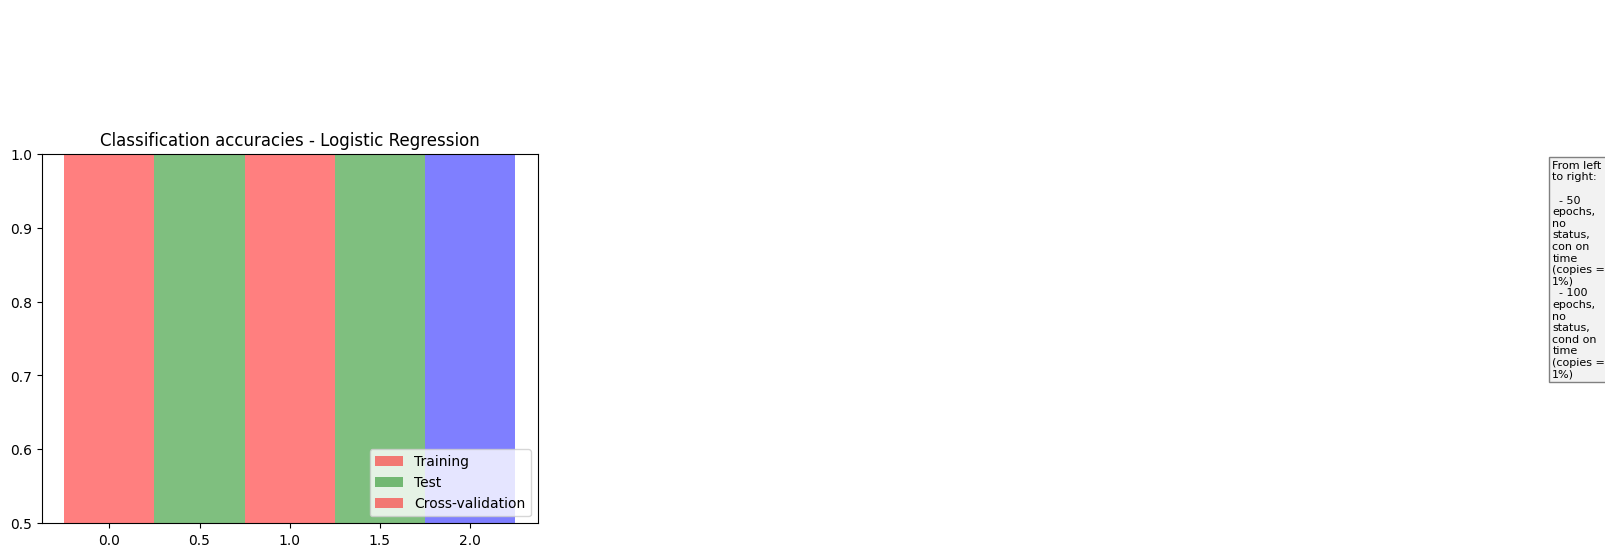

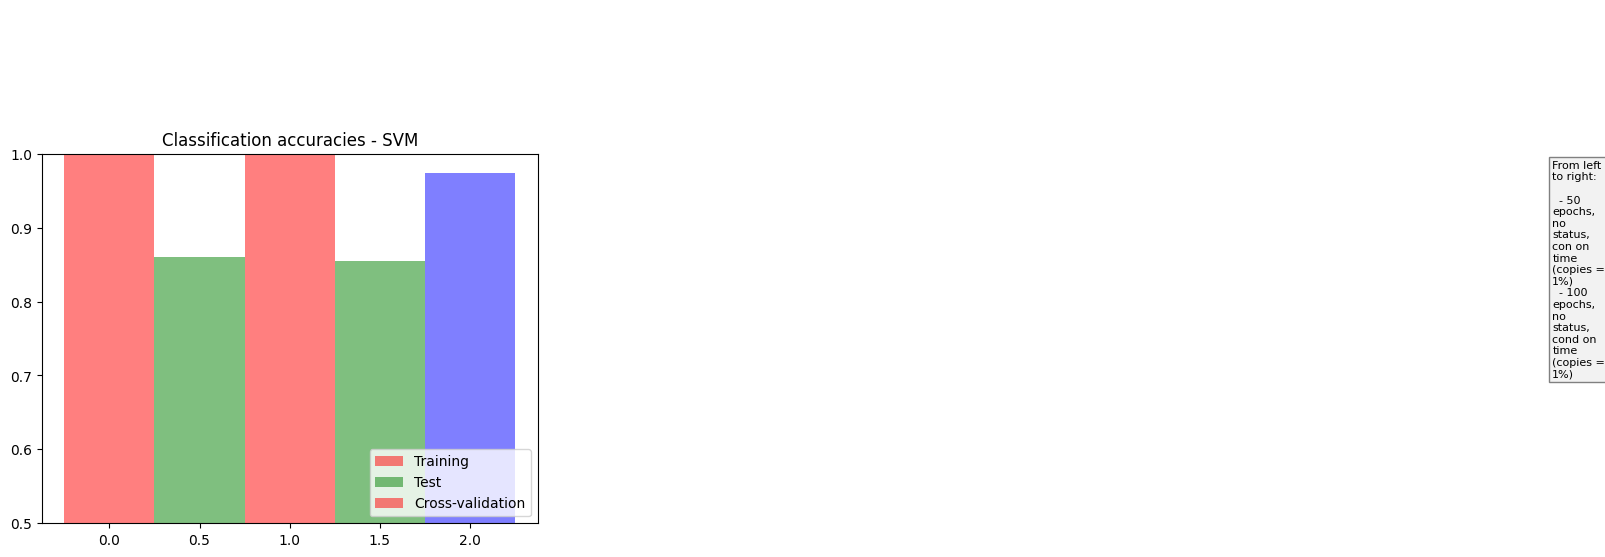

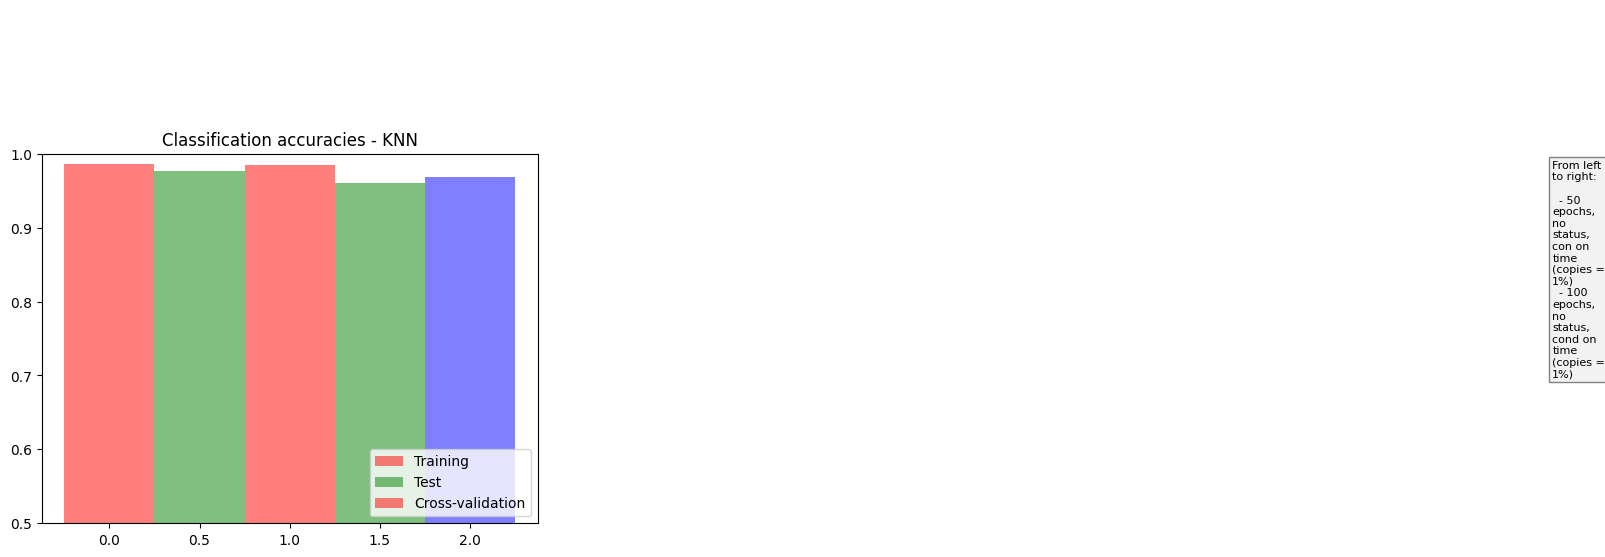

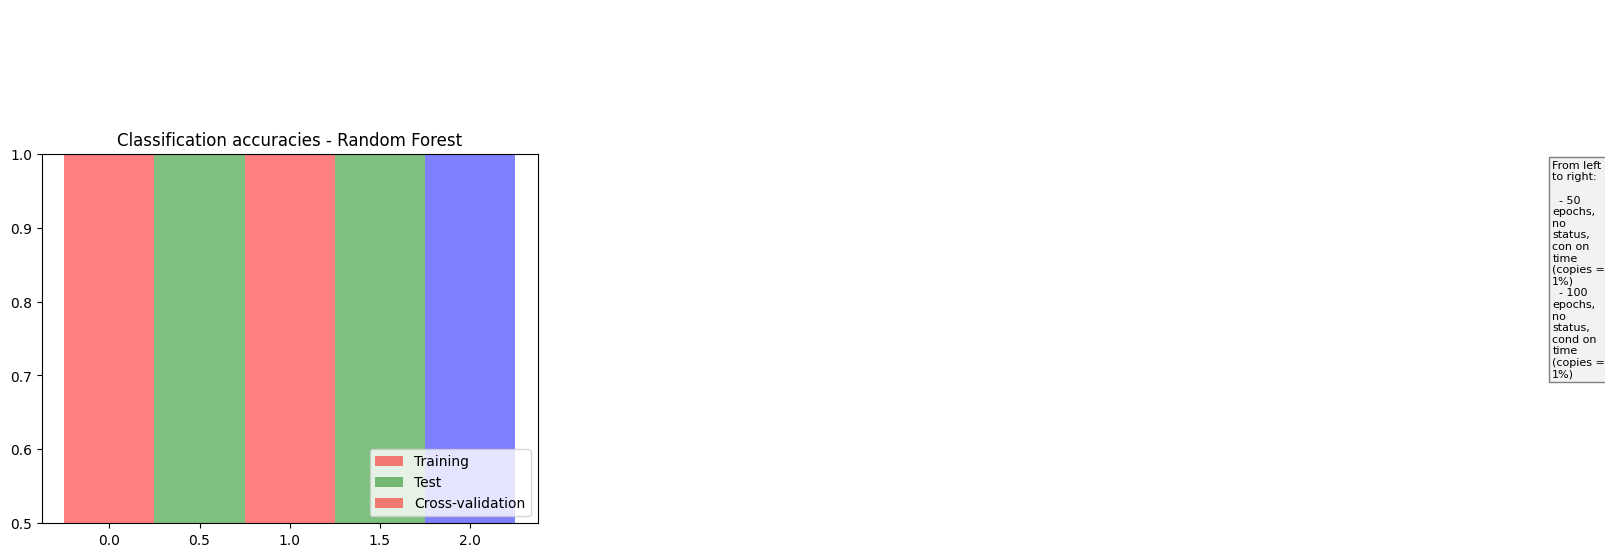

In [55]:
# plot barplots of the accuracies
barplot_classification_scores(classification_accuracy_scores, models_to_show, text_coord=(1, 0.7), samples_metadata=samples_metadata)